In [1]:
! pip show tensorflow
! pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 1.6.0
Summary: TensorFlow helps the tensors flow
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.5/dist-packages
Requires: protobuf, astor, gast, termcolor, numpy, absl-py, wheel, grpcio, tensorboard, six
Required-by: 


In [2]:
#import cv2 
import re, sys
import fnmatch, shutil, subprocess
from IPython.utils import io

import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from keras.models import *
from keras.layers import Input, concatenate, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import binary_crossentropy
import keras.backend as K

np.random.seed(1234)
import matplotlib.pyplot as plt
%matplotlib inline

print("\nSuccessfully imported packages!!!\n")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



Successfully imported packages!!!



In [3]:
#Settings
IMAGE_SIZE = 256
BASE_DIR = "/opt/output/"
TRAIN_IMG_DIR = BASE_DIR + "sunnybrook/norm/1/3/images/"
TRAIN_LBL_DIR = BASE_DIR + "sunnybrook/norm/1/3/challenge/"

TEST_IMG_DIR = BASE_DIR + "sunnybrook/norm/1/3/images/"
PRED_RESULT_DIR = BASE_DIR + "sunnybrook/norm/1/3/images/"

UNET_TRAIN_DIR = "/opt/heartsmart/unet_model/data/"
UNET_MODEL_DIR = "/opt/heartsmart/unet_model/models/"
TRAIN_TEST_SPLIT_RATIO = 0.1  # train/test split ratio

In [4]:
##################################
#
# Methods to extract sunnybrook contour files and corresponding image files 
#
###################################

SAX_SERIES_ALL = {
    'SC-HF-I-1': '0004',
    'SC-HF-I-2': '0106',
    'SC-HF-I-4': '0116',
    'SC-HF-I-5': '0156',
    'SC-HF-I-6': '0180',
    'SC-HF-I-7': '0209',
    'SC-HF-I-8': '0226',
    'SC-HF-I-9': '0241',
    'SC-HF-I-10': '0024',
    'SC-HF-I-11': '0043',
    'SC-HF-I-12': '0062',
    'SC-HF-I-40': '0134',
    'SC-HF-NI-3': '0379',
    'SC-HF-NI-4': '0501',
    'SC-HF-NI-7': '0523',
    'SC-HF-NI-12': '0286',
    'SC-HF-NI-11': '0270',
    'SC-HF-NI-13': '0304',
    'SC-HF-NI-14': '0331',
    'SC-HF-NI-15': '0359',
    'SC-HF-NI-31': '0401',
    'SC-HF-NI-33':'0424',
    'SC-HF-NI-34': '0446',
    'SC-HF-NI-36': '0474',
    'SC-HYP-1': '0550',
    'SC-HYP-3': '0650',
    'SC-HYP-6': '0767',
    'SC-HYP-7': '0007',
    'SC-HYP-8': '0796',
    'SC-HYP-9': '0003',
    'SC-HYP-10': '0579',
    'SC-HYP-11': '0601',
    'SC-HYP-12': '0629',
    'SC-HYP-37': '0702',
    'SC-HYP-38': '0734',
    'SC-HYP-40': '0755',
    'SC-N-2': '0898',
    'SC-N-3': '0915',
    'SC-N-5': '0963',
    'SC-N-6': '0981',
    'SC-N-7': '1009',
    'SC-N-9': '1031',
    'SC-N-10': '0851',
    'SC-N-11': '0878',
    'SC-N-40': '0944',
}



def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path                
        match = re.search(r"/([^/]*)/IM-(\d{4})-(\d{4}).dcm.label.npy", ctr_path)
        self.case = shrink_case(match.group(1))
        self.record = int(match.group(2))
        self.img_no = int(match.group(3))
    
    def __str__(self):
        return "<Contour for case %s, record %d image %d>" % (self.case, self.record, self.img_no)
    
    __repr__ = __str__

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def load_contour(contour, img_path, crop_size):
    # file = IM-0851-0127.dcm.npy
    filename = "IM-%s-%04d.dcm.npy" % (SAX_SERIES_ALL[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    img = np.load(full_path)
    label = np.load(contour.ctr_path)
    height, width = img.shape
    height_l, width_l = label.shape
    if height != crop_size or width !=crop_size:
        #print ("img: ", contour.img_no, height, width)
        #print ("lbl: ", height_l, width_l)
        img = crop_center(img,crop_size,crop_size)
        label = crop_center(label,crop_size,crop_size)
    return img, label

   
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-*dcm.label.npy')]
    print("Number of examples: {:d}".format(len(contours)))
    print("Shuffle data")
    np.random.shuffle(contours)
    print (contours[0], contours[-1])
    print("Number of examples after cleanup: {:d}".format(len(contours)))
    extracted = list(map(Contour, contours))
    print ("Contour 0 :", extracted[0].case, extracted[0].record, extracted[0].img_no)
    print ("Contour -1 :", extracted[-1].case, extracted[-1].record, extracted[-1].img_no) 
    return extracted

def get_contours_and_images(contours, img_path, crop_size):
    counter_img = 0
    counter_label = 0
    batchsz = len(contours)
    print("Processing {:d} images and labels...".format(len(contours)))
    for i in range(int(np.ceil(len(contours) / float(batchsz)))):
        batch = contours[(batchsz*i):(batchsz*(i+1))]
        if len(batch) == 0:
            break
        imgs, labels = [], []
        imgs2, labels2 = [], []
        for idx,ctr in enumerate(batch):
            try:
                img, label = load_contour(ctr, img_path, crop_size)
                imgs.append(img)
                labels.append(label)

                if idx % 100 == 0:
                    f, axs = plt.subplots(1,3,figsize=(12,12))
                    plt.subplot(131),plt.imshow(img, cmap = 'gray')
                    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
                    plt.subplot(132),plt.imshow(label, cmap = 'gray')
                    plt.title('label'), plt.xticks([]), plt.yticks([])
                    plt.subplot(133),plt.imshow(img, cmap = 'gray')
                    plt.imshow(label, 'jet', interpolation='none', alpha=0.5)
                    plt.title('label'), plt.xticks([]), plt.yticks([])
                    plt.show()

            except IOError:
                continue
    return imgs, labels

def extract_sunnybrook_training_data(crop_size=256): 
    SPLIT_RATIO = TRAIN_TEST_SPLIT_RATIO  # train/test split ratio
    print("Mapping ground truth contours to images...")
    ctrs = get_all_contours(TRAIN_LBL_DIR)
    print("Done mapping ground truth contours to images")
    test_ctrs = ctrs[0:int(SPLIT_RATIO*len(ctrs))]
    train_ctrs = ctrs[int(SPLIT_RATIO*len(ctrs)):]
    print("Split train_set:%d, test_set:%d"%(len(train_ctrs), len(test_ctrs)))
    print ("Extracting Training Images and Labels")
    train_imgs, train_labels = get_contours_and_images(train_ctrs, TRAIN_IMG_DIR, crop_size)
    print ("Extracting Test Images and Labels")
    test_imgs, test_labels = get_contours_and_images(test_ctrs, TRAIN_IMG_DIR, crop_size)
    print("Extracted Images train_set:%d, test_set:%d"%(len(train_imgs), len(test_imgs)))
    return train_imgs, train_labels, test_imgs, test_labels 


Mapping ground truth contours to images...
Number of examples: 805
Shuffle data
/opt/output/sunnybrook/norm/1/3/challenge/SC-HYP-1/IM-0550-0060.dcm.label.npy /opt/output/sunnybrook/norm/1/3/challenge/SC-HF-NI-4/IM-0501-0009.dcm.label.npy
Number of examples after cleanup: 805
Contour 0 : SC-HYP-1 550 60
Contour -1 : SC-HF-NI-4 501 9
Done mapping ground truth contours to images
Split train_set:725, test_set:80
Extracting Training Images and Labels
Processing 725 images and labels...


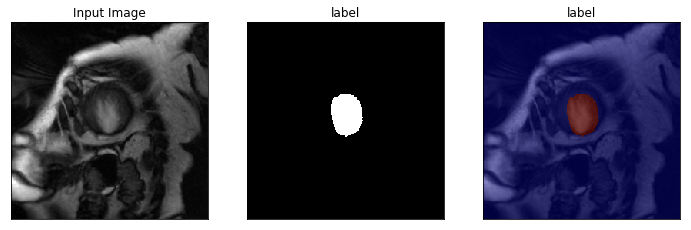

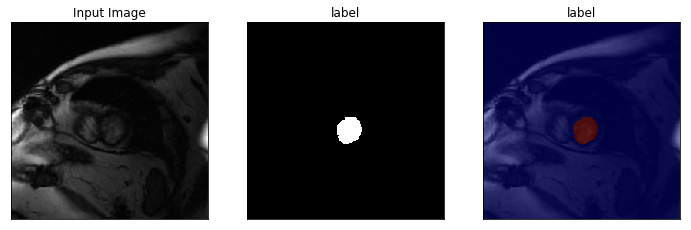

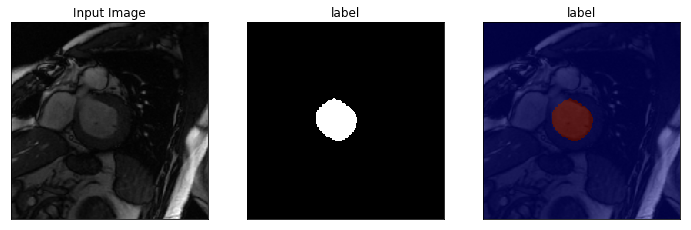

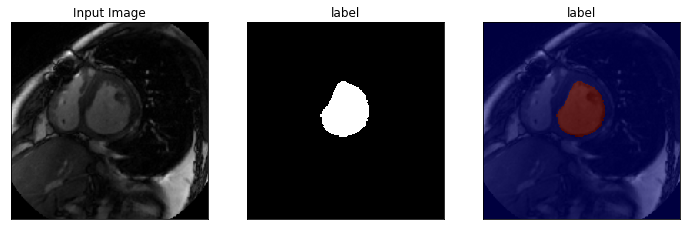

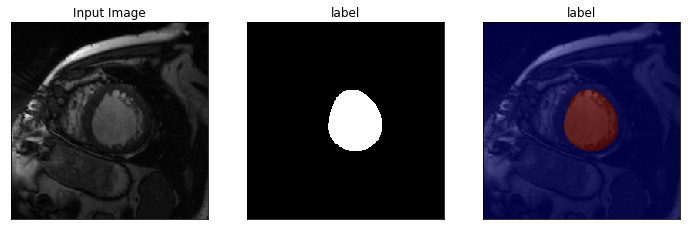

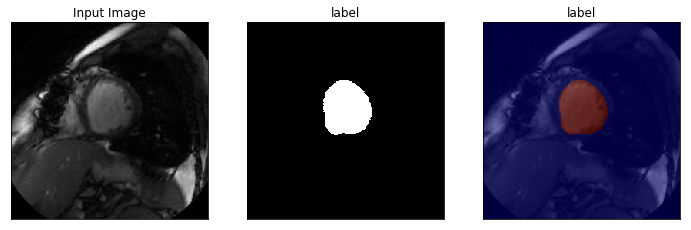

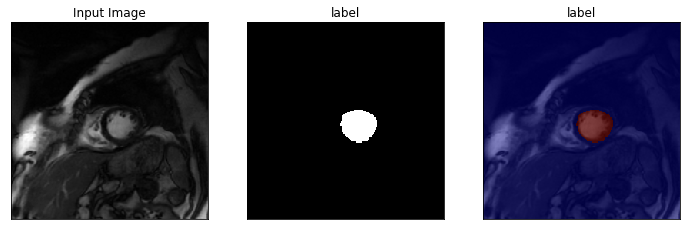

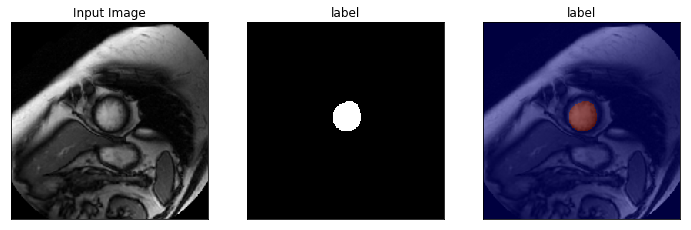

Extracting Test Images and Labels
Processing 80 images and labels...


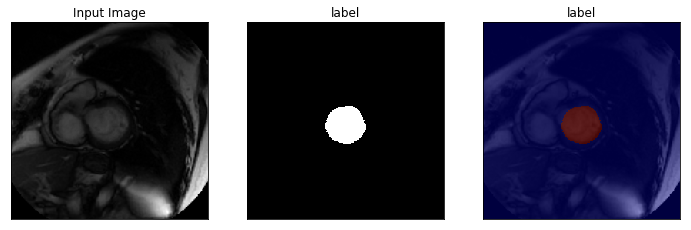

Extracted Images train_set:725, test_set:80
Mapping ground truth contours to images...
Number of examples: 805
Shuffle data
/opt/output/sunnybrook/norm/1/3/challenge/SC-HYP-10/IM-0579-0140.dcm.label.npy /opt/output/sunnybrook/norm/1/3/challenge/SC-HF-I-9/IM-0241-0247.dcm.label.npy
Number of examples after cleanup: 805
Contour 0 : SC-HYP-10 579 140
Contour -1 : SC-HF-I-9 241 247
Done mapping ground truth contours to images
Split train_set:725, test_set:80
Extracting Training Images and Labels
Processing 725 images and labels...


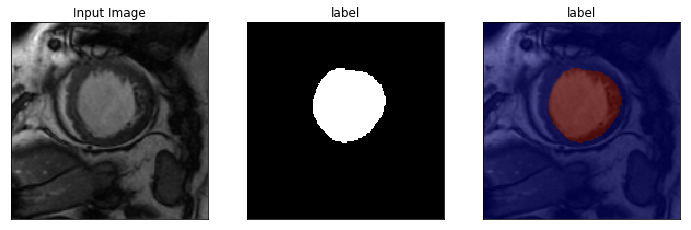

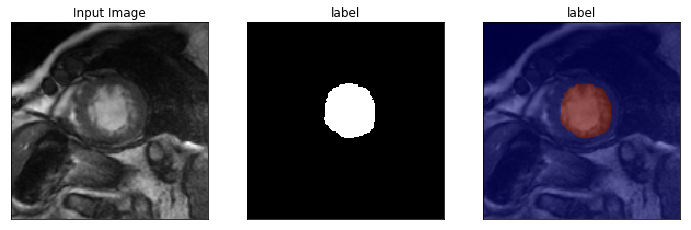

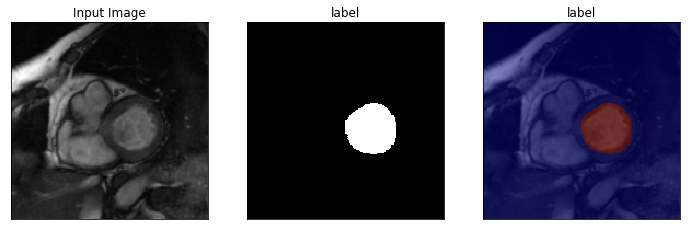

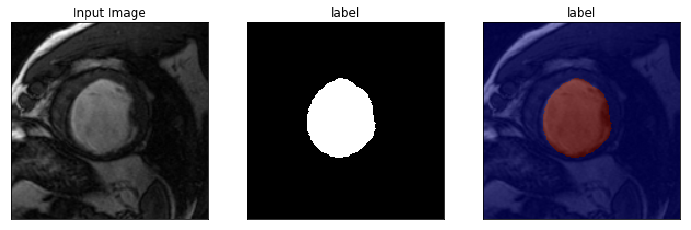

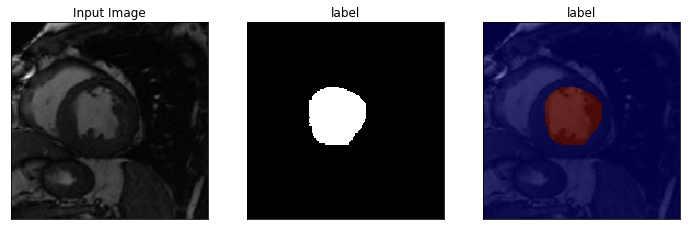

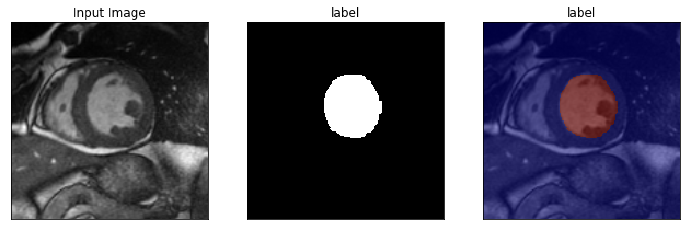

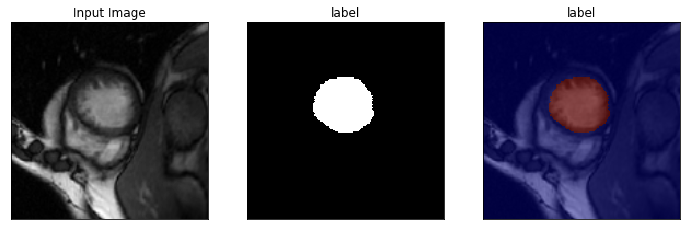

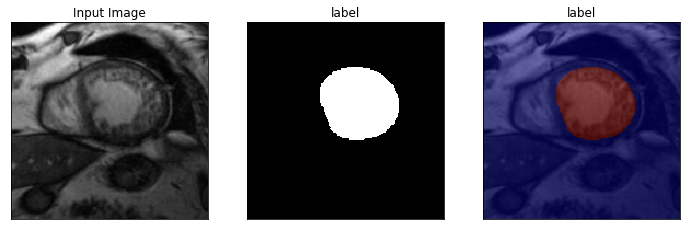

Extracting Test Images and Labels
Processing 80 images and labels...


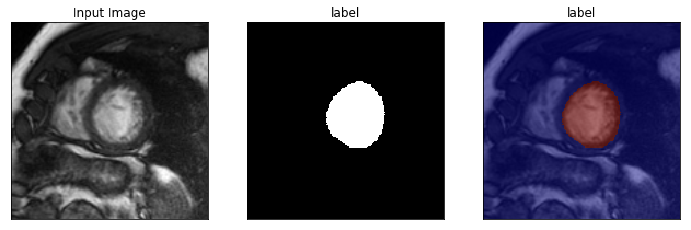

Extracted Images train_set:725, test_set:80


In [5]:
##Get sunnybrook images and labels with crop from center to get 256x256 images
train_imgs, train_labels, test_imgs, test_labels = extract_sunnybrook_training_data(crop_size=256)

##Get sunnybrook images and labels with crop from center to get 180x180 images

train_imgs2, train_labels2, test_imgs2, test_labels2 = extract_sunnybrook_training_data(crop_size=180)

 

In [6]:
#########################################
#
# Method to create  4d np array for images and labels and store the array in a directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

def create_training_data(imgs, lbls, save_file_path, file_prefix, rows=256, cols=256 ):
    i = 0
    print('-'*30)
    print("Creating training data..input size : ",len(imgs))
    print('-'*30)
    print("Converting data to np array")
    imgdatas = np.ndarray((len(imgs),rows,cols,1), dtype=np.int)
    imglabels = np.ndarray((len(imgs),rows,cols,1), dtype=np.uint8)
    for idx in range (len (imgs)):
        img = imgs[idx]
        label = lbls[idx]
        img = img_to_array(img)
        label = img_to_array(label)
        imgdatas[i] = img
        imglabels[i] = label
        i += 1
    imgfile = save_file_path + file_prefix +"_images.npy"
    lblfile = save_file_path + file_prefix +"_labels.npy"
    np.save(imgfile, imgdatas)
    np.save(lblfile, imglabels)

    print ("Shape of data & label np arrays : ", imgdatas.shape, imglabels.shape)
    print (imgdatas.max(), imgdatas.min(), imglabels.max(), imglabels.min())
    print('Saved data as: ', imgfile, lblfile )



In [7]:
### Create 256x256 size train/test data in 4d tensor shape and save them
save_location = UNET_TRAIN_DIR
tr_file_prefix = "sb_256_train"
tst_file_prefix = "sb_256_test"
create_training_data(train_imgs, train_labels, save_location, tr_file_prefix, rows=256, cols=256 )
create_training_data(test_imgs, test_labels, save_location, tst_file_prefix, rows=256, cols=256 )

### Create 180x180 size train/test data in 4d tensor shape and save them
tr_file_prefix = "sb_180_train"
tst_file_prefix = "sb_180_test"
create_training_data(train_imgs2, train_labels2, save_location, tr_file_prefix, rows=180, cols=180 )
create_training_data(test_imgs2, test_labels2, save_location, tst_file_prefix, rows=180, cols=180 )

#create_test_data(test_imgs, test_labels)

------------------------------
Creating training data..input size :  725
------------------------------
Converting data to np array
Shape of data & label np arrays :  (725, 256, 256, 1) (725, 256, 256, 1)
3071 0 1 0
Saved data as:  /opt/heartsmart/unet_model/data/sb_256_train_images.npy /opt/heartsmart/unet_model/data/sb_256_train_labels.npy
------------------------------
Creating training data..input size :  80
------------------------------
Converting data to np array
Shape of data & label np arrays :  (80, 256, 256, 1) (80, 256, 256, 1)
3005 0 1 0
Saved data as:  /opt/heartsmart/unet_model/data/sb_256_test_images.npy /opt/heartsmart/unet_model/data/sb_256_test_labels.npy
------------------------------
Creating training data..input size :  725
------------------------------
Converting data to np array
Shape of data & label np arrays :  (725, 180, 180, 1) (725, 180, 180, 1)
2479 0 1 0
Saved data as:  /opt/heartsmart/unet_model/data/sb_180_train_images.npy /opt/heartsmart/unet_model/da

## Start from here  if images and labels are already stored in unet_model/data directory

In [8]:
#########################################
#
# Methods to load 4d np array for images from ./data directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

MAX_PIXEL_VAL = 0


def load_images_and_labels(file_path, file_prefix):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = file_path + file_prefix +"_images.npy"
    labelfile = file_path + file_prefix +"_labels.npy"
    print ("Loading files : ", imgfile, labelfile)
    im = np.load(imgfile)
    lb = np.load(labelfile)
    images = im.astype('float32')
    labels = lb.astype('float32')
    print ("max : ", images.max())
    ##Normalize the pixel values, (between 0..1)
    MAX_PIXEL_VAL = images.max()
    images /= MAX_PIXEL_VAL
    #mean = imgs_train.mean(axis = 0)
    #imgs_train -= mean	
    print(images.shape, images.max(), images.min())
    print(labels.shape, labels.max(), labels.min())
    return images, labels


In [9]:
#########################################
#
# Loss functions
#
#########################################

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


def weighted_dice_coeff(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score


def weighted_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 1 - weighted_dice_coeff(y_true, y_pred, weight)
    return loss


def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
                                          (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)


def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + (1 - weighted_dice_coeff(y_true, y_pred, weight))
    return loss

In [10]:
###############################
#
# Unet models
#
################################

class myUnet(object):

    def __init__(self, img_rows = 256, img_cols = 256):

        self.img_rows = img_rows
        self.img_cols = img_cols

    def load_data(self):
        
        file_loc = UNET_TRAIN_DIR
        train_file_prefix = "sb_256_train"
        test_file_prefix = "sb_256_test"
        self.train_images, self.train_labels = load_images_and_labels(file_loc, train_file_prefix)
        self.test_images, self.test_labels = load_images_and_labels(file_loc, test_file_prefix)


    def get_unet_small(self):
        
        '''
        Input shape
        4D tensor with shape: (samples, channels, rows, cols) if data_format='channels_first' 
        or 4D tensor with shape: (samples, rows, cols, channels) if data_format='channels_last' (default format).
        
        Output shape
        4D tensor with shape: (samples, filters, new_rows, new_cols) if data_format='channels_first' or 
        4D tensor with shape: (samples, new_rows, new_cols, filters) if data_format='channels_last'. 
        rows and cols values might have changed due to padding.
        '''

        print('-'*30)
        print ("Building smaller version of U-net model")
        print('-'*30)
        
        inputs = Input((self.img_rows, self.img_cols,1))

        conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        print ("conv1 shape:",conv1.shape)
        conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        print ("conv1 shape:",conv1.shape)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        print ("pool1 shape:",pool1.shape)

        conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        print ("conv2 shape:",conv2.shape)
        conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        print ("conv2 shape:",conv2.shape)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        print ("pool2 shape:",pool2.shape)

        conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        print ("conv3 shape:",conv3.shape)
        conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        print ("conv3 shape:",conv3.shape)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        print ("pool3 shape:",pool3.shape)

        conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.2)(conv4)
        
        up5 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
        merge5 = concatenate([conv3,up5], axis = 3)
        conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
        conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        
        up6 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
        merge6 = concatenate([conv2,up6], axis = 3)
        conv6 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv1,up7], axis = 3)
        conv7 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        conv8 = Conv2D(1, 1, activation = 'sigmoid')(conv7)

        self.model = Model(input = inputs, output = conv8)

        self.model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
        #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


    def get_unet(self):
        
        '''
        Input shape
        4D tensor with shape: (samples, channels, rows, cols) if data_format='channels_first' 
        or 4D tensor with shape: (samples, rows, cols, channels) if data_format='channels_last' (default format).
        
        Output shape
        4D tensor with shape: (samples, filters, new_rows, new_cols) if data_format='channels_first' or 
        4D tensor with shape: (samples, new_rows, new_cols, filters) if data_format='channels_last'. 
        rows and cols values might have changed due to padding.
        '''
        print('-'*30)
        print ("Building U-net model")
        print('-'*30)
        
        inputs = Input((self.img_rows, self.img_cols,1))

        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        print ("conv1 shape:",conv1.shape)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        print ("conv1 shape:",conv1.shape)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        print ("pool1 shape:",pool1.shape)

        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        print ("conv2 shape:",conv2.shape)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        print ("conv2 shape:",conv2.shape)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        print ("pool2 shape:",pool2.shape)

        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        print ("conv3 shape:",conv3.shape)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        print ("conv3 shape:",conv3.shape)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        print ("pool3 shape:",pool3.shape)

        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        #drop4 = Dropout(0.5)(conv4)
        drop4 = conv4
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.2)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

        self.model = Model(input = inputs, output = conv10)

        self.model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
        #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    def get_unet2(self):

        inputs = Input((self.img_rows, self.img_cols,1))
        
        conv0 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        print ("conv0 shape:",conv0.shape)
        conv0 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
        print ("conv1 shape:",conv0.shape)
        pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
        print ("pool1 shape:",pool0.shape)
        
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
        print ("conv1 shape:",conv1.shape)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        print ("conv1 shape:",conv1.shape)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        print ("pool1 shape:",pool1.shape)

        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        print ("conv2 shape:",conv2.shape)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        print ("conv2 shape:",conv2.shape)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        print ("pool2 shape:",pool2.shape)

        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        print ("conv3 shape:",conv3.shape)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        print ("conv3 shape:",conv3.shape)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        print ("pool3 shape:",pool3.shape)

        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.2)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.2)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
        up10 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
        merge10 = merge([conv0,up10], mode = 'concat', concat_axis = 3)
        conv10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
        conv10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)

        
        
        #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv11 = Conv2D(1, 1, activation = 'sigmoid')(conv10)

        self.model = Model(input = inputs, output = conv11)

        self.model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
        #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


    def train_and_predict(self, batch_size = 4, nb_epoch = 10):
        print('-'*30)
        print("loading data")
        self.load_data()
        print("loading data done")
        print('-'*30)
        
        model_file = UNET_MODEL_DIR+'unet_sk2.hdf5' #path to save the weights with best model
        model_checkpoint = ModelCheckpoint(model_file, monitor='loss',verbose=1, save_best_only=True)
        print('-'*30)
        print('Fitting model...')
        print('-'*30)
        self.model.fit(self.train_images, self.train_labels, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

        print('-'*30)
        print('predict test data')
        self.predictions = self.model.predict(self.test_images, batch_size=1, verbose=1)
        
        pred_file = "predictions_sk2.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        np.save(pred_file, self.predictions)
        print('-'*30)
        
    
    def train_with_augmentation(self, batch_size = 4, nb_epoch = 10 ):
        print('-'*30)
        print("loading data")
        self.load_data()
        sample_size, x_val, y_val, ax = self.train_images.shape
        
        print("loading data done")
        print('-'*30)


        model_file = UNET_MODEL_DIR+'unet_aug2.hdf5' #path to save the weights with best model
        model_checkpoint = ModelCheckpoint(model_file, monitor='loss',verbose=1, save_best_only=True)
        
        # we create two instances with the same arguments
        data_gen_args = dict(
                             rotation_range=90.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2)
        
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)

        # Provide the same seed and keyword arguments to the fit and flow methods
        seed = 1
        image_generator = image_datagen.flow(self.train_images, y=None, seed = seed, batch_size=sample_size)
        mask_generator = mask_datagen.flow(self.train_labels,  y=None, seed = seed, batch_size=sample_size)
        train_generator = zip(image_generator, mask_generator)
        
        print('-'*30)
        print('Fitting model...')
        
        self.model.fit(self.train_images, self.train_labels, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
        MAX_AUG=2
        augmentation_round = 0
        for img_tr, mask_tr in train_generator:
                print ("Augmentation round: ", augmentation_round+1, img_tr.shape)
                s, x1, y1, p = img_tr.shape
                self.model.fit(img_tr, mask_tr, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
                augmentation_round += 1
                if (augmentation_round == MAX_AUG):
                      break
            
        
        print('-'*30)
        print('Run Predictions on test data')
        self.predictions = self.model.predict(self.train_images, batch_size=1, verbose=1)
        
        pred_file = "predictions_aug_sk1.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        np.save(pred_file, self.predictions)
        print('-'*30)
        

    def train_with_augmentation2(self, batch_size = 4, nb_epoch = 10 ):
        print('-'*30)
        print("loading data")
        self.load_data()
        sample_size, x_val, y_val, ax = self.train_images.shape
        
        print("loading data done")
        print('-'*30)


        model_file = UNET_MODEL_DIR+'unet_aug2.hdf5' #path to save the weights with best model
        model_checkpoint = ModelCheckpoint(model_file, monitor='loss',verbose=1, save_best_only=True)
        
        # we create two instances with the same arguments
        data_gen_args = dict(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=90.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2)
        
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)

        # Provide the same seed and keyword arguments to the fit and flow methods
        seed = 1
        image_datagen.fit(self.train_images, augment=True, seed=seed)
        mask_datagen.fit(self.train_labels, augment=True, seed=seed)

        # Provide the same seed and keyword arguments to the fit and flow methods
        seed = 1
        image_generator = image_datagen.flow(self.train_images, y=None, seed = seed, batch_size=sample_size)
        mask_generator = mask_datagen.flow(self.train_labels,  y=None, seed = seed, batch_size=sample_size)
        train_generator = zip(image_generator, mask_generator)
        
        print('-'*30)
        print('Fitting model...')
        
        self.model.fit(self.train_images, self.train_labels, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
        MAX_AUG=2
        augmentation_round = 0
        for img_tr, mask_tr in train_generator:
                print ("Augmentation round: ", augmentation_round+1, img_tr.shape)
                s, x1, y1, p = img_tr.shape
                self.model.fit(img_tr, mask_tr, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
                augmentation_round += 1
                if (augmentation_round == MAX_AUG):
                      break
            
        
        print('-'*30)
        print('Run Predictions on test data')
        self.predictions = self.model.predict(self.train_images, batch_size=1, verbose=1)
        
        pred_file = "predictions_aug_sk1.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        np.save(pred_file, self.predictions)
        print('-'*30)
        

    def save_img(self):
        pred_file = "predictions.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        print("array to image")
        imgs = np.load(pred_file)
        for i in range(imgs.shape[0]):
            img = imgs[i]
            img = array_to_img(img)
            img.save("./%d.jpg"%(i))



In [11]:
#################
# Create a U-Net model, train the model and run the predictions and save the trained weights and predictions
############

myunet = myUnet()
#model = myunet.get_unet_small()
myunet.get_unet()

myunet.model.summary()

res = myunet.train_and_predict(batch_size = 4, nb_epoch = 10)
#res = myunet.train_with_augmentation(model, batch_size = 4, nb_epoch = 10)



------------------------------
Building U-net model
------------------------------
conv1 shape: (?, 256, 256, 64)
conv1 shape: (?, 256, 256, 64)
pool1 shape: (?, 128, 128, 64)
conv2 shape: (?, 128, 128, 128)
conv2 shape: (?, 128, 128, 128)
pool2 shape: (?, 64, 64, 128)
conv3 shape: (?, 64, 64, 256)
conv3 shape: (?, 64, 64, 256)
pool3 shape: (?, 32, 32, 256)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:161: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

max :  3071.0
(725, 256, 256, 1) 1.0 0.0
(725, 256, 256, 1) 1.0 0.0
------------------------------
load np arrays of images and labels...
------------------------------
Loading files :  /opt/heartsmart/unet_model/data/sb_256_test_images.npy /opt/heartsmart/unet_model/data/sb_256_test_labels.npy
max :  3005.0
(80, 256, 256, 1) 1.0 0.0
(80, 256, 256, 1) 1.0 0.0
loading data done
------------------------------
------------------------------
Fitting model...
------------------------------
Train on 580 samples, validate on 145 samples
Epoch 1/10
580/580 [==============================] - 36s 62ms/step - loss: 0.9180 - dice_coeff: 0.2565 - val_loss: 0.4501 - val_dice_coeff: 0.6253

Epoch 00001: loss improved from inf to 0.91795, saving model to /opt/heartsmart/unet_model/models/unet_sk2.hdf5
Epoch 2/10
580/580 [==============================] - 29s 50ms/step - loss: 0.4298 - dice_coeff: 0.6514 - val_loss: 0.3088 - val_dice_coeff: 0.7420

Epoch 00002: loss improved from 0.91795 to 0.42976, sa

------------------------------
load np arrays of images and labels...
------------------------------
Loading files :  /opt/heartsmart/unet_model/data/sb_256_test_images.npy /opt/heartsmart/unet_model/data/sb_256_test_labels.npy
max :  3005.0
(80, 256, 256, 1) 1.0 0.0
(80, 256, 256, 1) 1.0 0.0
1.0 0.0


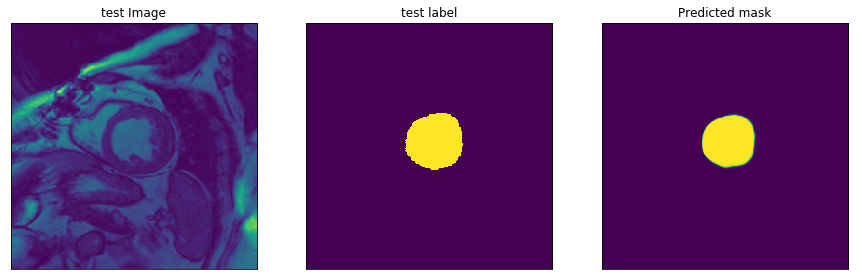

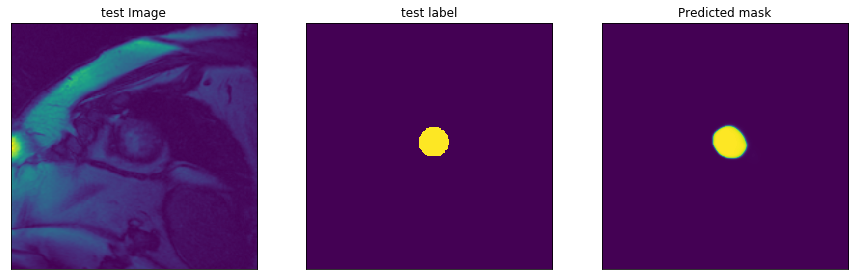

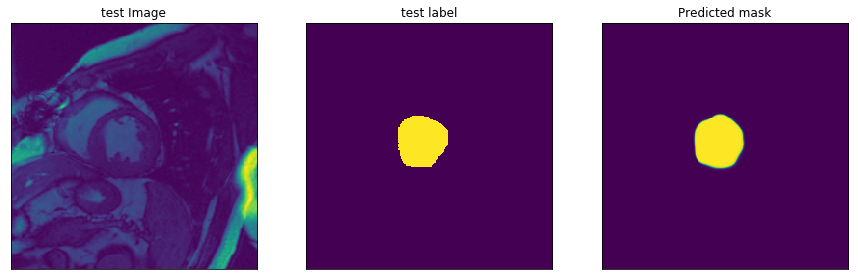

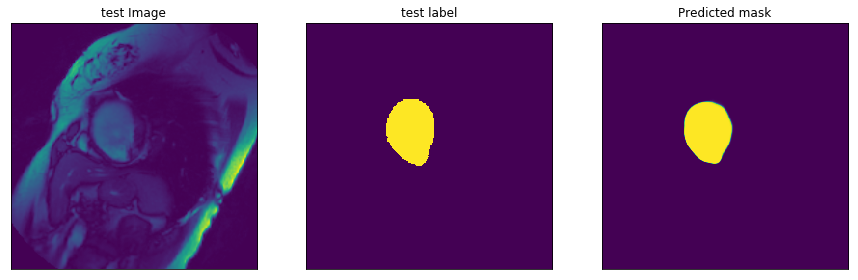

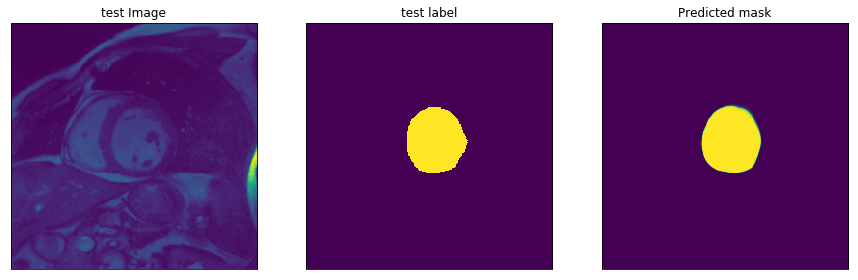

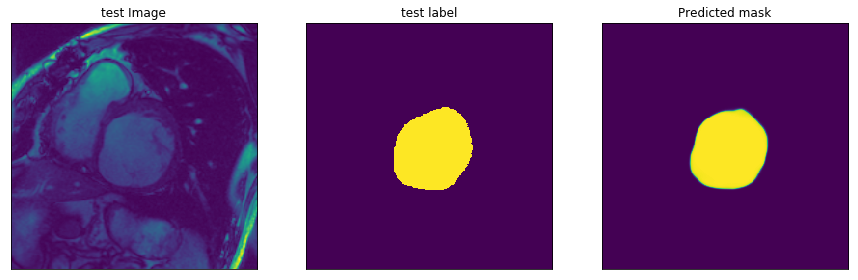

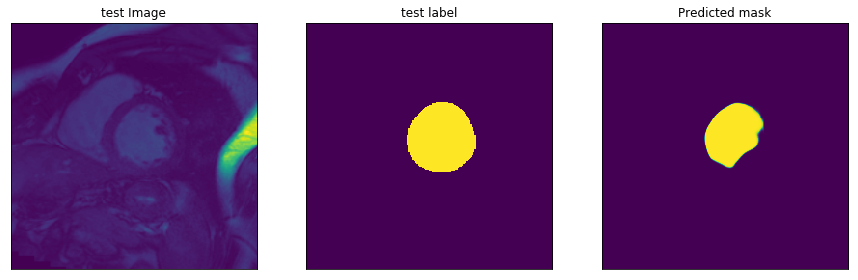

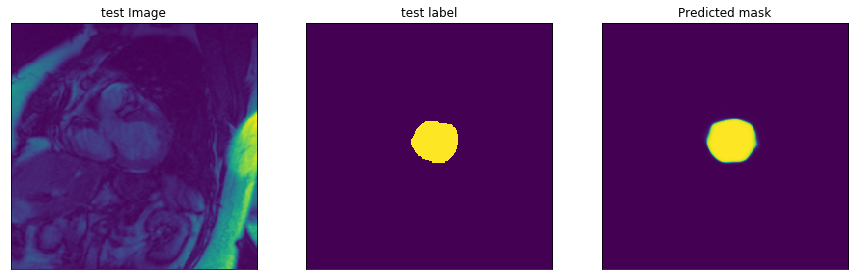

In [13]:
##################################
#
# Method to visually compare the predictions with actual labels
#
################################

file_loc = UNET_TRAIN_DIR
test_file_prefix = "sb_256_test"
ts , tl= load_images_and_labels(file_loc, test_file_prefix)
pred = myunet.predictions
print (pred.max(), pred.min())

##Print few images wih actual labels and predictions
for i in range (8,16):
    f, axs = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131),plt.imshow(ts[i].reshape(256, 256))
    plt.title('test Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(tl[i].reshape(256, 256))
    plt.title('test label'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(pred[i].reshape(256, 256))
    plt.title('Predicted mask'), plt.xticks([]), plt.yticks([])
#     plt.subplot(132),plt.imshow(ts[i].reshape(256, 256)), plt.imshow(tl[i].reshape(256, 256), 'jet', interpolation='none', alpha=0.5)
#     plt.title('test label'), plt.xticks([]), plt.yticks([])
#     plt.subplot(133),plt.imshow(ts[i].reshape(256, 256)), plt.imshow(pred[i].reshape(256, 256), 'jet', interpolation='none', alpha=0.5)
#     plt.title('Predicted mask'), plt.xticks([]), plt.yticks([])
    plt.show()
    

# img = imgs[5].reshape(256,256)

# plt.imshow(img, alpha=0.6)

------------------------------
Loading Test images and labels...
------------------------------
load np arrays of images and labels...
------------------------------
Loading files :  /opt/heartsmart/unet_model/data/sb_256_test_images.npy /opt/heartsmart/unet_model/data/sb_256_test_labels.npy
max :  3005.0
(80, 256, 256, 1) 1.0 0.0
(80, 256, 256, 1) 1.0 0.0
------------------------------
Creating U-net model...
------------------------------
Building U-net model
------------------------------
conv1 shape: (?, 256, 256, 64)
conv1 shape: (?, 256, 256, 64)
pool1 shape: (?, 128, 128, 64)
conv2 shape: (?, 128, 128, 128)
conv2 shape: (?, 128, 128, 128)
pool2 shape: (?, 64, 64, 128)
conv3 shape: (?, 64, 64, 256)
conv3 shape: (?, 64, 64, 256)
pool3 shape: (?, 32, 32, 256)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:161: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


------------------------------
Loading the pre-trained weights...
------------------------------
Run predictions...
80/80 [==============================] - 1s 19ms/step
Pred data : (80, 256, 256, 1) 1.0 0.0
------------------------------


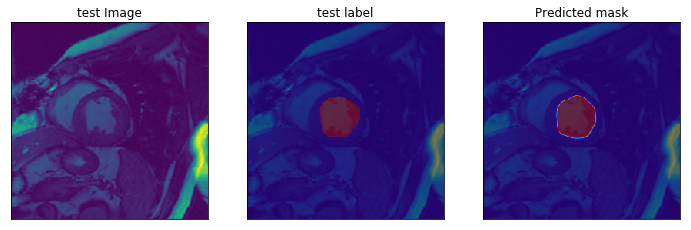

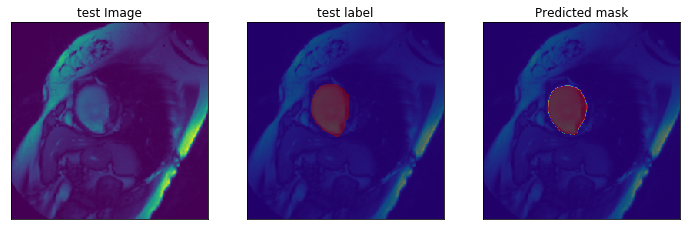

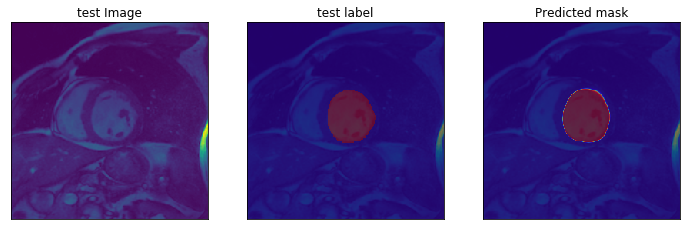

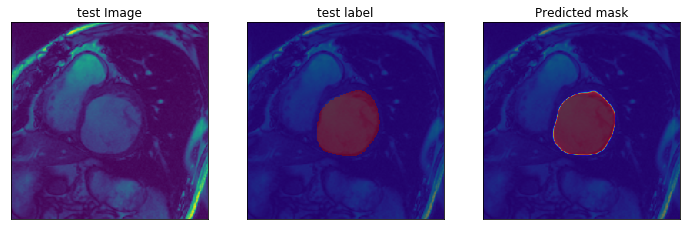

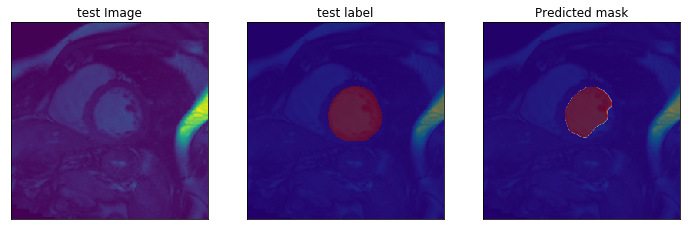

In [14]:
##########################
#
# Method to load the trained weights into U-net model and run the predictions
#
########################################
model_file = UNET_MODEL_DIR+'unet_sk2.hdf5' #path to save the weights with best model
file_loc = UNET_TRAIN_DIR
test_file_prefix = "sb_256_test"
print('-'*30)
print ("Loading Test images and labels...")
ts , tl= load_images_and_labels(file_loc, test_file_prefix)

print('-'*30)
print ("Creating U-net model...")
myunet = myUnet()
myunet.get_unet()
print('-'*30)
print ("Loading the pre-trained weights...")
myunet.model.load_weights(model_file)
print('-'*30)

print('Run predictions...')
pred = myunet.model.predict(ts, batch_size=1, verbose=1)
print ("Pred data :", pred.shape, pred.max(), pred.min())
print('-'*30)



for i in range (10,15):
    f, axs = plt.subplots(1,3,figsize=(12,12))
    plt.subplot(131),plt.imshow(ts[i].reshape(256, 256))
    plt.title('test Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(ts[i].reshape(256, 256)), plt.imshow(tl[i].reshape(256, 256), 'jet', interpolation='none', alpha=0.5)
    plt.title('test label'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(ts[i].reshape(256, 256)), plt.imshow(pred[i].reshape(256, 256), 'jet', interpolation='none', alpha=0.5)
    plt.title('Predicted mask'), plt.xticks([]), plt.yticks([])
    plt.show()

## ............ Backup section  (test code)....................

In [ ]:

np.where(np.logical_and(pred>0, pred<1))
b = pred[(pred>0.5) & (pred<1)]

In [ ]:
b.shape

In [ ]:
plt.bar(np.arange(len(b)), b)
plt.show()

In [ ]:
def predict_one():
    image_batch, mask_batch = next(validation_generator)
    predicted_mask_batch = model.predict(image_batch)
    image = image_batch[0]
    predicted_mask = predicted_mask_batch[0].reshape(SIZE)
    plt.imshow(image)
    plt.imshow(predicted_mask, alpha=0.6)

In [ ]:
myunet = myUnet()
model = myunet.get_unet()
model.summary()

res = myunet.train_and_predict(model, batch_size = 4, nb_epoch = 2)

In [ ]:
ts = load_test_data()
tl = load_test_labels()


myunet = myUnet()
model = myunet.get_unet()
#model.load_weights('unet.hdf5')
model.load_weights('unet_small.hdf5')
print('predict test data')
pred = model.predict(ts, batch_size=1, verbose=1)

print (pred.max(), pred.min())

for i in range (4,8):
    plt.subplot(131),plt.imshow(ts[i].reshape(256, 256))
    plt.title('test Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(tl[i].reshape(256, 256))
    plt.title('test label'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(pred[i].reshape(256, 256))
    plt.title('Predicted mask'), plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
print (pred.max(), pred.min())



In [ ]:
myunet = myUnet()
model = myunet.get_unet2()
model.summary()

In [ ]:
sq_img = ts[4].reshape(256, 256)
clahe = cv2.createCLAHE(tileGridSize=(1, 1))
cl_img = clahe.apply(sq_img)
plt.imshow(pred[i].reshape(256, 256))
plt.title('Predicted mask'), plt.xticks([]), plt.yticks([])
plt.show()